# Clustering
# Data

In [1]:
import pandas as pd
articles = pd.read_csv('articles.tsv', sep='\t', names=['title', 'text'])
articles.head()

,title,text
0,-hou,-hou is a suffix (part added to the end of a w...
1,.htaccess,.htaccess is a type of computer file for the c...
2,16-cell,"In four dimensional geometry, a 16-cell, is a ..."
3,2007 Universal Forum of Cultures,The Universal Forum of Cultures Monterrey 2007...
4,20th century in literature,Literature of the 20th century refers to world...


In [3]:
# preprocess using tf idf vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english')
text_data = vectorizer.fit_transform(articles['text'])

Note: I used TfidfVectorizer in this example, but I could also have used other sentences vectorizers (e.g. Something like BERT, but this is probably out of the scope of this assignment and rather for e.g. a course on information retrieval instead of data mining).
# How many clusters?
Since this are just random wikipedia articles, I can't manually estimate the number of clusters, so let's use an algorithm for this.
We've seen following during the lecture: After the optimal number of clusters is reached, the SSE will
still decrease, but the decrease will be less outspoken.
## Using K-Means

In [2]:
import numpy as np

def calculate_sse(cluster_centers, X):
    # Based on code from here: https://towardsdatascience.com/bisecting-k-means-algorithm-clustering-in-machine-learning-1bd32be71c1c
    cluster_centers = kmeans.cluster_centers_
    sse = 0
    for point, label in zip(X, kmeans.labels_):
        sse += np.square(point-cluster_centers[label]).sum()
    return sse

In [6]:
# Perform K-means for different numbers of clusters and plot the SSE
from sklearn.cluster import KMeans
from tqdm import tqdm
import matplotlib.pyplot as plt

MIN_CLUSTERS = 2
MAX_CLUSTERS = 50
#amount_of_clusters_to_try = MAX_CLUSTERS - MIN_CLUSTERS + 1
sse_list = [] # List of tuples containing (number of clusters, SSE)


for k in range(MIN_CLUSTERS, MAX_CLUSTERS+1):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(text_data)

    # Evaluate the clustering performance
    sse = calculate_sse(kmeans.cluster_centers_, text_data)
    sse_list.append((k, sse))

    print(f"For k = {k}, the SSE is {sse}")

For k = 2, the SSE is 2073.077401112965
For k = 3, the SSE is 2064.049319680482
For k = 4, the SSE is 2056.1938371764527
For k = 5, the SSE is 2050.4017907728617
For k = 6, the SSE is 2042.195679623588
For k = 7, the SSE is 2034.8565961313768
For k = 8, the SSE is 2029.043015237322
For k = 9, the SSE is 2023.3987748624936
For k = 10, the SSE is 2019.8676094757943
For k = 11, the SSE is 2014.7568266108976
For k = 12, the SSE is 2013.3673480836128
For k = 13, the SSE is 2007.614577914361
For k = 14, the SSE is 2002.9159370684556
For k = 15, the SSE is 2002.168350191205
For k = 16, the SSE is 1996.5717506433825
For k = 17, the SSE is 1992.0890692344644
For k = 18, the SSE is 1992.0943515453814
For k = 19, the SSE is 1987.8920911067546
For k = 20, the SSE is 1985.7276620177222
For k = 21, the SSE is 1982.2883305697064
For k = 22, the SSE is 1979.5130748832873
For k = 23, the SSE is 1977.6236533569358
For k = 24, the SSE is 1975.841494850644
For k = 25, the SSE is 1973.1741860206337
For k =

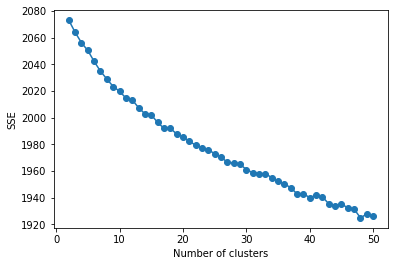

In [8]:
# plot the SSE
plt.plot([x[0] for x in sse_list], [x[1] for x in sse_list], '-o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.savefig('cluster_count_sse.png')

As you can see in the graph, the SSE keeps decreasing, but still hasn't reached a point where the decrease is significantly less outspoken (like the graph in the lecture). Because we already have some difference between sse's of less than 1, I don't think this point will still come, so I'll try another method to find the number of clusters.
You can argue that there is a small change at the 9th element, but its so small, it's probably not the number we're searching for (unless we can't find a better number).
## Using DBScan

100%|██████████| 14/14 [01:34<00:00,  6.77s/it]


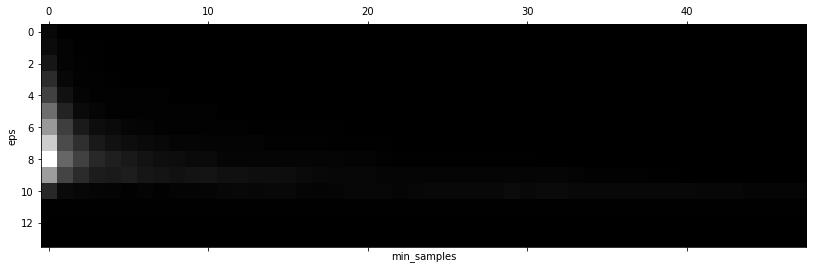

In [62]:
from sklearn.cluster import DBSCAN
import numpy as np
from tqdm import tqdm

eps_range = np.arange(0.8, 1.5, 0.05)
min_samples_range = np.arange(2, 50, 1)
m = np.zeros((len(eps_range), len(min_samples_range)))

for eps_idx, eps in enumerate(tqdm(eps_range)):
    for min_samples_idx, min_samples in enumerate(min_samples_range):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(text_data)
        no_clusters = len(set(dbscan.labels_))
        m[eps_idx][min_samples_idx] = no_clusters

plt.matshow(m, cmap=plt.get_cmap('gray'))
plt.xlabel('min_samples')
plt.ylabel('eps')
plt.show()

Note that the indices along the axis are still wrong. The y-axis should range from 0.8 to 1.5, and the x-axis should range from 2 to 12. We get the most clusters with eps 1.2 and of course the lower the minimum samples, the higher the number of clusters.

100%|██████████| 48/48 [00:05<00:00,  8.07it/s]


Text(0, 0.5, 'Number of clusters')

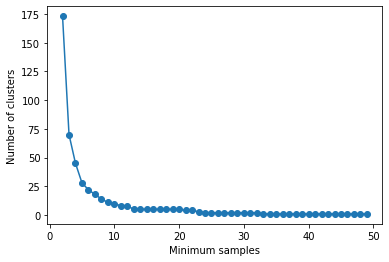

100%|██████████| 48/48 [00:05<00:00,  8.16it/s]


Text(0, 0.5, 'Number of clusters')

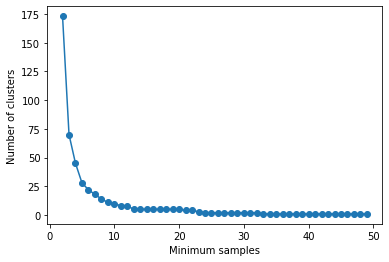

In [51]:
# Keep eps fixed now and create a plot of the number of clusters for different min_samples
min_samples_range = np.arange(2, 50, 1)
min_samples_list = []
no_clusters_list = []
for min_sample in tqdm(min_samples_range):
    dbscan = DBSCAN(eps=1.2, min_samples=min_sample).fit(text_data)
    no_clusters = len(set(dbscan.labels_))

    min_samples_list.append(min_sample)
    no_clusters_list.append(no_clusters)

plt.plot(min_samples_list, no_clusters_list, '-o')
plt.xlabel('Minimum samples')
plt.ylabel('Number of clusters')

The number of clusters is heading quite fast to one large cluster, so also not really useful to determine the number of clusters.

In [60]:
dbscan = DBSCAN(eps=1.2, min_samples=10).fit(text_data)
no_clusters = len(set(dbscan.labels_))
print(f"An estimated number of clusters is {no_clusters}")

An estimated number of clusters is 10


In [69]:
eps_range = np.arange(1.1, 1.5, 0.005)
for eps in eps_range:
    dbscan = DBSCAN(eps=eps, min_samples=40).fit(text_data)
    no_clusters = len(set(dbscan.labels_))
    print(f"For eps = {eps}, the number of clusters is {no_clusters}")

For eps = 1.1, the number of clusters is 1
For eps = 1.105, the number of clusters is 1
For eps = 1.1099999999999999, the number of clusters is 1
For eps = 1.1149999999999998, the number of clusters is 1
For eps = 1.1199999999999997, the number of clusters is 1
For eps = 1.1249999999999996, the number of clusters is 1
For eps = 1.1299999999999994, the number of clusters is 1
For eps = 1.1349999999999993, the number of clusters is 1
For eps = 1.1399999999999992, the number of clusters is 1
For eps = 1.1449999999999991, the number of clusters is 1
For eps = 1.149999999999999, the number of clusters is 1
For eps = 1.154999999999999, the number of clusters is 1
For eps = 1.1599999999999988, the number of clusters is 1
For eps = 1.1649999999999987, the number of clusters is 1
For eps = 1.1699999999999986, the number of clusters is 1
For eps = 1.1749999999999985, the number of clusters is 1
For eps = 1.1799999999999984, the number of clusters is 1
For eps = 1.1849999999999983, the number of 

The most number of clusters is for eps = 1.305, so I'll use that. Let's now take a look at how the elements are distributed along the cluster.

In [74]:
dbscan = DBSCAN(eps=1.305, min_samples=40).fit(text_data)
unique_elements, counts_elements = np.unique(dbscan.labels_, return_counts=True)
for unique_element, count_element in zip(unique_elements, counts_elements):
    print(f"For cluster {unique_element}, there are {count_element} elements")

For cluster -1, there are 1631 elements
For cluster 0, there are 124 elements
For cluster 1, there are 100 elements
For cluster 2, there are 102 elements
For cluster 3, there are 59 elements
For cluster 4, there are 44 elements
For cluster 5, there are 40 elements


Almost everything is in one cluster, so this is also not a great solution.
## Visualizing the clusters
Since there isn't a clear number of clusters, we'll try to visualize the data in a 2D space. I'll use TSNE for this, since that gives usually better results than PCA.


C:\Users\arnod\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\arnod\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2100 samples in 0.000s...
[t-SNE] Computed neighbors for 2100 samples in 0.132s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2100
[t-SNE] Computed conditional probabilities for sample 2000 / 2100
[t-SNE] Computed conditional probabilities for sample 2100 / 2100
[t-SNE] Mean sigma: 0.287826
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.594688
[t-SNE] KL divergence after 1000 iterations: 1.901657


[Text(0.5, 1.0, 'T-SNE projection')]

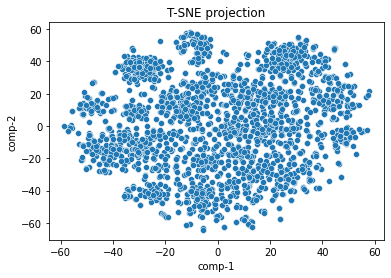

In [8]:
# Code based on https://www.datatechnotes.com/2020/11/tsne-visualization-example-in-python.html
from sklearn.manifold import TSNE
from numpy import reshape
import seaborn as sns
import pandas as pd

x = text_data
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(x)

df = pd.DataFrame()
# df["y"] = y # Not usable yet, since no labels defined
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2",data=df).set(title="T-SNE projection (TfIdf)")

There is indeed as DBSCAN predicted one large cluster and a few smaller ones. Maybe our problem is that TfIdf is not very good for this assignment, so we might have to use something else. Let's embed the sentences using the sentence-transformers library. Let's use the [all-MiniLM-L6-v2 model](https://www.sbert.net/docs/pretrained_models.html), since it is general purpose and has a good performance. Note that similarity here can be scored using dot product, cosine similarity or euclidean distance (accoording to the description).


In [3]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')
sentence_embeddings = model.encode(articles['text'], show_progress_bar=True)

Batches:   0%|          | 0/66 [00:00<?, ?it/s]

C:\Users\arnod\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\arnod\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\arnod\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2100 samples in 0.000s...
[t-SNE] Computed neighbors for 2100 samples in 2.872s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2100
[t-SNE] Computed conditional probabilities for sample 2000 / 2100
[t-SNE] Computed conditional probabilities for sample 2100 / 2100
[t-SNE] Mean sigma: 0.238328
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.906166
[t-SNE] KL divergence after 1000 iterations: 1.644095


[Text(0.5, 1.0, 'T-SNE projection (sentence-transformers)')]

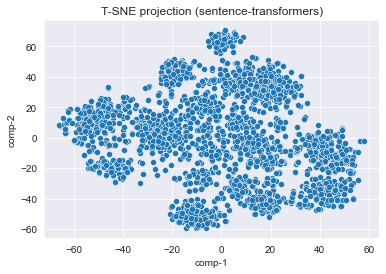

In [4]:
# Transformation done, let's visualize again

from sklearn.manifold import TSNE
from numpy import reshape
import seaborn as sns
import pandas as pd

x = sentence_embeddings
tsne = TSNE(n_components=2, verbose=1, random_state=123, metric='cosine') # Using cosine similarity, since this was specified in the model description
z = tsne.fit_transform(x)

df = pd.DataFrame()
# df["y"] = y # Not usable yet, since no labels defined
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2",data=df).set(title="T-SNE projection (sentence-transformers)")

This already shows some more clusters of similar sizes. Let's also try gensim, to see if this one works better or not.

In [15]:
# Rerun K-means on those embeddings
# Perform K-means for different numbers of clusters and plot the SSE
from sklearn.cluster import KMeans
from tqdm import tqdm
import matplotlib.pyplot as plt

MIN_CLUSTERS = 2
MAX_CLUSTERS = 50
#amount_of_clusters_to_try = MAX_CLUSTERS - MIN_CLUSTERS + 1
sse_list = [] # List of tuples containing (number of clusters, SSE)


for k in range(MIN_CLUSTERS, MAX_CLUSTERS+1):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(sentence_embeddings)

    # Evaluate the clustering performance
    sse = calculate_sse(kmeans.cluster_centers_, sentence_embeddings)
    sse_list.append((k, sse))

    print(f"For k = {k}, the SSE is {sse}")

For k = 2, the SSE is 1934.2286684513092
For k = 3, the SSE is 1904.5871836543083
For k = 4, the SSE is 1876.9796594977379
For k = 5, the SSE is 1852.4437683224678
For k = 6, the SSE is 1831.4354965686798
For k = 7, the SSE is 1810.3182627558708
For k = 8, the SSE is 1790.5550091862679
For k = 9, the SSE is 1773.5359278917313
For k = 10, the SSE is 1757.9230455756187
For k = 11, the SSE is 1740.877884119749
For k = 12, the SSE is 1728.4741541147232
For k = 13, the SSE is 1716.6609346270561
For k = 14, the SSE is 1708.7872840464115
For k = 15, the SSE is 1699.6899286210537
For k = 16, the SSE is 1692.3824716806412
For k = 17, the SSE is 1681.8136243522167
For k = 18, the SSE is 1673.1554025113583
For k = 19, the SSE is 1665.8976733088493
For k = 20, the SSE is 1657.6432675123215
For k = 21, the SSE is 1649.8898693919182
For k = 22, the SSE is 1647.74843236804
For k = 23, the SSE is 1638.5457302629948
For k = 24, the SSE is 1635.4277939200401
For k = 25, the SSE is 1631.6228485703468
For

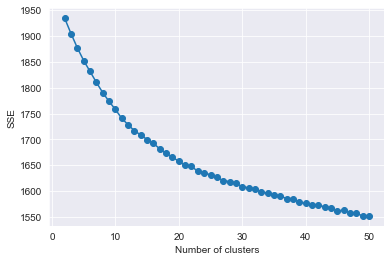

In [16]:
# Plot the SSE
plt.plot([x[0] for x in sse_list], [x[1] for x in sse_list], '-o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.savefig('cluster_count_sse.png')

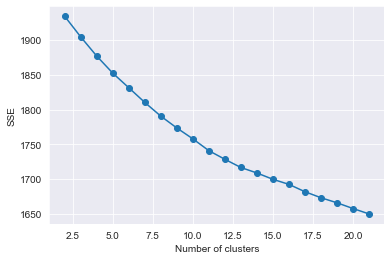

In [18]:
plt.plot([x[0] for x in sse_list[:20]], [x[1] for x in sse_list[:20]], '-o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.savefig('cluster_count_sse.png')

There is a slight elbow in the curve at 11 clusters.

In [4]:
from sklearn.cluster import DBSCAN
import numpy as np
from tqdm import tqdm

eps_range = np.arange(0.8, 1.5, 0.05)
min_samples_range = np.arange(2, 30, 1)
m = np.zeros((len(eps_range), len(min_samples_range)))

for eps_idx, eps in enumerate(tqdm(eps_range)):
    for min_samples_idx, min_samples in enumerate(min_samples_range):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(sentence_embeddings)
        no_clusters = len(set(dbscan.labels_))
        m[eps_idx][min_samples_idx] = no_clusters

100%|██████████| 14/14 [09:41<00:00, 41.50s/it]


NameError: name 'plt' is not defined

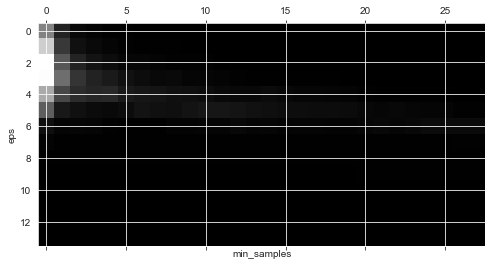

In [5]:
import matplotlib.pyplot as plt
plt.matshow(m, cmap=plt.get_cmap('gray'))
plt.xlabel('min_samples')
plt.ylabel('eps')
plt.show()

100%|██████████| 18/18 [00:30<00:00,  1.67s/it]


Text(0, 0.5, 'Number of clusters')

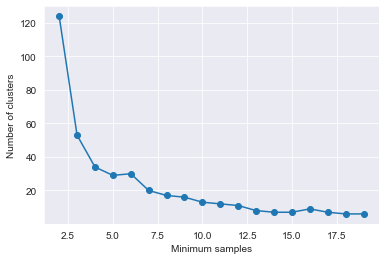

In [7]:
# Keep eps fixed now and create a plot of the number of clusters for different min_samples
min_samples_range = np.arange(2, 20, 1)
min_samples_list = []
no_clusters_list = []
for min_sample in tqdm(min_samples_range):
    dbscan = DBSCAN(eps=1.0, min_samples=min_sample).fit(sentence_embeddings)
    no_clusters = len(set(dbscan.labels_))

    min_samples_list.append(min_sample)
    no_clusters_list.append(no_clusters)

plt.plot(min_samples_list, no_clusters_list, '-o')
plt.xlabel('Minimum samples')
plt.ylabel('Number of clusters')

In [13]:
dbscan = DBSCAN(eps=1.1, min_samples=10).fit(sentence_embeddings)
no_clusters = len(set(dbscan.labels_))
print(f"An estimated number of clusters is {no_clusters}")

eps_range = np.arange(1.0, 1.2, 0.025)
for eps in eps_range:
    dbscan = DBSCAN(eps=eps, min_samples=10).fit(sentence_embeddings)
    no_clusters = len(set(dbscan.labels_))
    print(f"For eps = {eps}, the number of clusters is {no_clusters}")

An estimated number of clusters is 4
For eps = 1.0, the number of clusters is 13
For eps = 1.025, the number of clusters is 17
For eps = 1.0499999999999998, the number of clusters is 12
For eps = 1.0749999999999997, the number of clusters is 10
For eps = 1.0999999999999996, the number of clusters is 4
For eps = 1.1249999999999996, the number of clusters is 2
For eps = 1.1499999999999995, the number of clusters is 2
For eps = 1.1749999999999994, the number of clusters is 2


In [14]:
dbscan = DBSCAN(eps=1.06, min_samples=10).fit(sentence_embeddings)
unique_elements, counts_elements = np.unique(dbscan.labels_, return_counts=True)
for unique_element, count_element in zip(unique_elements, counts_elements):
    print(f"For cluster {unique_element}, there are {count_element} elements")

For cluster -1, there are 1100 elements
For cluster 0, there are 11 elements
For cluster 1, there are 198 elements
For cluster 2, there are 646 elements
For cluster 3, there are 14 elements
For cluster 4, there are 72 elements
For cluster 5, there are 22 elements
For cluster 6, there are 9 elements
For cluster 7, there are 17 elements
For cluster 8, there are 11 elements


Also here, we have one large cluster and a few smaller clusters, so the result is not very relible.

## Based on 2D TSNE
There is still no clear answer to the number of clusters, so let's try to determine the number of clusters based on the 2D TSNE values.

In [64]:
tsne_values = tsne.fit_transform(sentence_embeddings)

# df = pd.DataFrame()
# df["y"] = y # Not usable yet, since no labels defined
# df["comp-1"] = z[:,0]
# df["comp-2"] = z[:,1]

from sklearn.cluster import KMeans
from tqdm import tqdm
import matplotlib.pyplot as plt

MIN_CLUSTERS = 2
MAX_CLUSTERS = 30
sse_list = [] # List of tuples containing (number of clusters, SSE)

for k in range(MIN_CLUSTERS, MAX_CLUSTERS+1):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(tsne_values)

    # Evaluate the clustering performance
    sse = calculate_sse(kmeans.cluster_centers_, tsne_values)
    sse_list.append((k, sse))

    print(f"For k = {k}, the SSE is {sse}")

C:\Users\arnod\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\arnod\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\arnod\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2100 samples in 0.000s...
[t-SNE] Computed neighbors for 2100 samples in 3.415s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2100
[t-SNE] Computed conditional probabilities for sample 2000 / 2100
[t-SNE] Computed conditional probabilities for sample 2100 / 2100
[t-SNE] Mean sigma: 0.238328
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.906166
[t-SNE] KL divergence after 1000 iterations: 1.644095
For k = 2, the SSE is 1951064.4804565907
For k = 3, the SSE is 1185471.8435129523
For k = 4, the SSE is 849783.2279949933
For k = 5, the SSE is 661779.3520269804
For k = 6, the SSE is 566963.8753788993
For k = 7, the SSE is 486326.8544660583
For k = 8, the SSE is 415618.27699409425
For k = 9, the SSE is 353583.74652191997
For k = 10, the SSE is 309380.2379719019
For k = 11, the SSE is 271976.4984858036
For k = 12, the SSE is 238060.32672294974
For k = 13, the SSE is 206786.30141572282
For k = 14

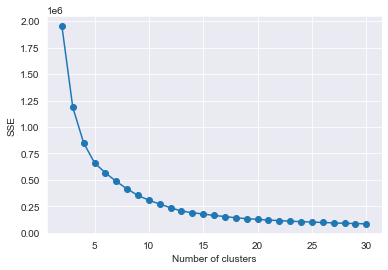

In [65]:
plt.plot([x[0] for x in sse_list], [x[1] for x in sse_list], '-o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.savefig('cluster_count_sse.png')

At the start, the SSE is decreases fastly. Around 12 clusters, the large decreasing steps have dissapeared, so let's take this as amount of clusters.



## Conclusion
There isn't a clear exact number of clusters, but something around 12 gave some slight changes in our test methods, so let's try to make some clusters based on this.


# K-means
K-means has problems when clusters are of different size, density or have non-globular shapes.
K-means also has problems when the data contains outliers (use median instead of mean).
## K-means

In [94]:
N_CLUSTERS = 13

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=0).fit(sentence_embeddings)
label = kmeans.fit_predict(sentence_embeddings)

In [95]:
import seaborn as sns

from sklearn.manifold import TSNE
from numpy import reshape
import seaborn as sns
import pandas as pd

x = sentence_embeddings
tsne = TSNE(n_components=2, verbose=1, random_state=123, metric='cosine') # Using cosine similarity, since this was specified in the model description
z = tsne.fit_transform(x)

C:\Users\arnod\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\arnod\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\arnod\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2100 samples in 0.001s...
[t-SNE] Computed neighbors for 2100 samples in 3.666s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2100
[t-SNE] Computed conditional probabilities for sample 2000 / 2100
[t-SNE] Computed conditional probabilities for sample 2100 / 2100
[t-SNE] Mean sigma: 0.238328
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.906166
[t-SNE] KL divergence after 1000 iterations: 1.644095


[Text(0.5, 1.0, 'T-SNE projection (sentence-transformers)')]

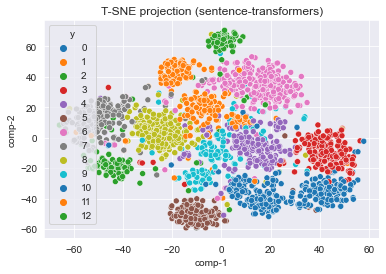

In [96]:

df = pd.DataFrame()
df['title'] = articles['title']
df["y"] = label
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2",data=df, hue="y", palette=sns.color_palette("tab10", n_colors=N_CLUSTERS)).set(title="T-SNE projection (sentence-transformers)")
# sns.scatterplot(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1],
#             marker="X", s=80, label="centroids")

In [97]:
# Show a few sentences per cluster
unique_labels = np.unique(label, return_counts=True)
for label in unique_labels[0]:
    print(f"Cluster {label}:")
    print(df[df['y'] == label]['title'].values)
    print("\n")

Cluster 0:
['16-cell' '3D projection' '4D' 'Adjacent' 'Affine symmetric group'
 'Altitude' 'Amateur astronomy' 'Analytic geometry' 'Angle' 'Area'
 'Astrometry' 'Astronomical Almanac' 'Astronomical clock' 'Astronomy'
 'Axis of rotation' 'Barycenter' 'Base (geometry)' 'Bolometric magnitude'
 'Calabi-Yau manifold' 'Catalan solid' 'Catenary' 'Celestia'
 'Celestial coordinate system' 'Celestial equator' 'Celestial navigation'
 'Celestial sphere' 'Circumference' 'Collimated light' 'Concentric'
 'Congruence' 'Convex set' 'Coronagraph' 'Cross section (geometry)'
 'Crystallography' 'Curve' 'Declination' 'Diagonal' 'Diameter'
 'Differential geometry' 'Dilation (geometry)' 'Dimension'
 'Displacement vector' 'Double helix' 'Elliptic curve'
 'Equality (mathematics)' 'Euclidean distance' 'Euclidean geometry'
 'Euclidean space' 'Extinction (astronomy)' 'Extragalactic astronomy'
 'Extraterrestrial sky' 'Flatland' 'Flexagon' 'Floor plan'
 'Flyby (spaceflight)' 'Folio' 'Fomalhaut b' 'Form' 'Galactic hal

In [105]:
# Also get the transformation of the cluster centers
points_and_centers = np.append(x, kmeans.cluster_centers_, axis=0)
z_incl_centers = tsne.fit_transform(points_and_centers)
tsne_centers = z_incl_centers[-N_CLUSTERS:]

C:\Users\arnod\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\arnod\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\arnod\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2113 samples in 0.004s...
[t-SNE] Computed neighbors for 2113 samples in 1.827s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2113
[t-SNE] Computed conditional probabilities for sample 2000 / 2113
[t-SNE] Computed conditional probabilities for sample 2113 / 2113
[t-SNE] Mean sigma: 0.241424
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.929733
[t-SNE] KL divergence after 1000 iterations: 1.681396


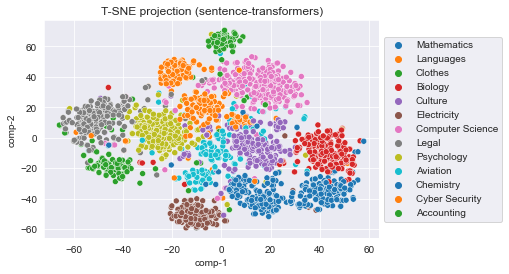

In [114]:
interpretation = ["Mathematics", "Languages", "Clothes", "Biology", "Culture", "Electricity", "Computer Science", "Legal", "Psychology", "Aviation", "Chemistry", "Cyber Security", "Accounting"]
# Plot the same data as above, but with the cluster labels
ax = sns.scatterplot(x="comp-1", y="comp-2",data=df, hue="y", palette=sns.color_palette("tab10", n_colors=N_CLUSTERS))
ax.set(title="T-SNE projection (sentence-transformers)")
handles, labels  =  ax.get_legend_handles_labels()
ax.legend(handles, interpretation, loc='center left', bbox_to_anchor=(1, 0.5))

# for i, label in enumerate(unique_labels[0]):
#     current_cluster_center = tsne_centers[i]
#     plt.annotate(interpretation[label], current_cluster_center, size=10)

C:\Users\arnod\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\arnod\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\arnod\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2100 samples in 0.005s...
[t-SNE] Computed neighbors for 2100 samples in 1.670s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2100
[t-SNE] Computed conditional probabilities for sample 2000 / 2100
[t-SNE] Computed conditional probabilities for sample 2100 / 2100
[t-SNE] Mean sigma: 0.238328
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.906166
[t-SNE] KL divergence after 1000 iterations: 1.644095
Cluster 0:
['Alternator' 'Arc flash' 'Arc welding' 'Autotransformer'
 'Availability factor' 'Battery (crime)' 'Battery charger' 'Black start'
 'Brownout (electricity)' 'Busbar' 'Cable tray' 'Capacitance'
 'Cathode ray' 'Cogeneration' 'Companhia de Electricidade de Macau'
 'Contactor' "Coulomb's law" 'Current transformer' 'Diesel generator'
 'Direct current' 'Disconnecting switch' 'Distributed generation'
 'Distribution board' 'Eddy current' 'Edge effect' 'Electric arc'
 'Electric charge' 'Electr

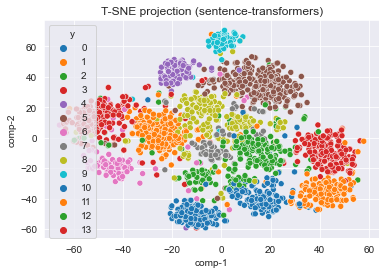

In [115]:
# Let's run on a higher number of clusters to see whether the generated clusters still have a logical structure
N_CLUSTERS = 14

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=0).fit(sentence_embeddings)
label = kmeans.fit_predict(sentence_embeddings)

from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd

x = sentence_embeddings
tsne = TSNE(n_components=2, verbose=1, random_state=123,
            metric='cosine')  # Using cosine similarity, since this was specified in the model description
z = tsne.fit_transform(x)

df = pd.DataFrame()
df['title'] = articles['title']
df["y"] = label
df["comp-1"] = z[:, 0]
df["comp-2"] = z[:, 1]

sns.scatterplot(x="comp-1", y="comp-2", data=df, hue="y", palette=sns.color_palette("tab10", n_colors=N_CLUSTERS)).set(
    title="T-SNE projection (sentence-transformers)")

unique_labels = np.unique(label, return_counts=True)
for label in unique_labels[0]:
    print(f"Cluster {label}:")
    print(df[df['y'] == label]['title'].values)
    print("\n")


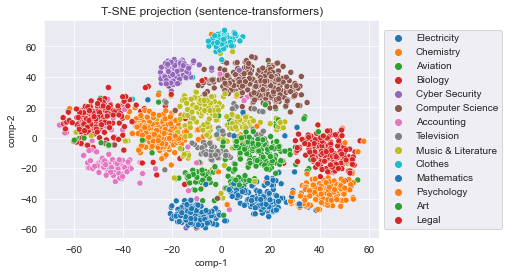

In [116]:
interpretation = ["Electricity", "Chemistry", "Aviation", "Biology", "Cyber Security", "Computer Science", "Accounting", "Television", "Music & Literature", "Clothes", "Mathematics", "Psychology", "Art", "Legal"]

ax = sns.scatterplot(x="comp-1", y="comp-2",data=df, hue="y", palette=sns.color_palette("tab10", n_colors=N_CLUSTERS))
ax.set(title="T-SNE projection (sentence-transformers)")
handles, labels  =  ax.get_legend_handles_labels()
ax.legend(handles, interpretation, loc='center left', bbox_to_anchor=(1, 0.5))

In [118]:
# Create some functions, to prevent code duplication
def get_text_per_cluster(N_CLUSTERS):
    kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=0).fit(sentence_embeddings)
    label = kmeans.fit_predict(sentence_embeddings)

    x = sentence_embeddings
    tsne = TSNE(n_components=2, verbose=1, random_state=123,
                metric='cosine')  # Using cosine similarity, since this was specified in the model description
    z = tsne.fit_transform(x)

    df = pd.DataFrame()
    df['title'] = articles['title']
    df["y"] = label
    df["comp-1"] = z[:, 0]
    df["comp-2"] = z[:, 1]

    sns.scatterplot(x="comp-1", y="comp-2", data=df, hue="y", palette=sns.color_palette("tab10", n_colors=N_CLUSTERS)).set(
        title="T-SNE projection (sentence-transformers)")

    unique_labels = np.unique(label, return_counts=True)
    for label in unique_labels[0]:
        print(f"Cluster {label}:")
        print(df[df['y'] == label]['title'].values)
        print("\n")

def get_plot_using_interpretation(interpretion):
    ax = sns.scatterplot(x="comp-1", y="comp-2",data=df, hue="y", palette=sns.color_palette("tab10", n_colors=N_CLUSTERS))
    ax.set(title="T-SNE projection (sentence-transformers)")
    handles, labels  =  ax.get_legend_handles_labels()
    ax.legend(handles, interpretation, loc='center left', bbox_to_anchor=(1, 0.5))

C:\Users\arnod\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\arnod\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\arnod\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2100 samples in 0.000s...
[t-SNE] Computed neighbors for 2100 samples in 1.652s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2100
[t-SNE] Computed conditional probabilities for sample 2000 / 2100
[t-SNE] Computed conditional probabilities for sample 2100 / 2100
[t-SNE] Mean sigma: 0.238328
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.906166
[t-SNE] KL divergence after 1000 iterations: 1.644095
Cluster 0:
['Abnormal psychology' 'Adaptive unconscious' 'Addiction' 'Aliteracy'
 'Alter ego' 'Anal retentive' 'Anal stage' 'Analytical psychology'
 'Anecdote' 'Anger management' 'Anhedonia' 'Anthropomorphism'
 'Anti-social behaviour order' 'Applied behavior analysis' 'Archetype'
 'Audiophile' 'Autism' 'Autogenic training' 'Automatic behaviour'
 'Basic needs' 'Beauty' 'Behaviorism' 'Behaviour' 'Bias' 'Bullying'
 'Carrot and Stick' 'Cheerleader effect' 'Child development'
 'Child sexuality' 'Clai

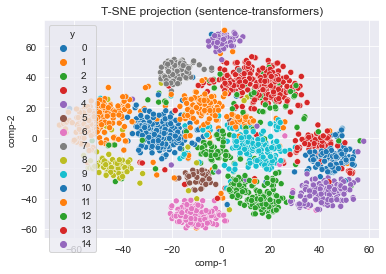

In [120]:
get_text_per_cluster(15)

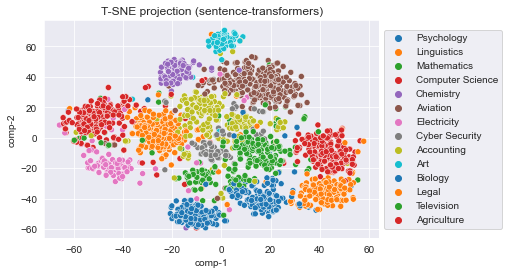

In [122]:
interpretation = ["Psychology", "Linguistics", "Mathematics", "Computer Science", "Chemistry", "Aviation", "Electricity", "Cyber Security", "Accounting", "Art", "Biology", "Legal", "Television", "Agriculture", "Clothes"]
get_plot_using_interpretation(interpretation)

C:\Users\arnod\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\arnod\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\arnod\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2100 samples in 0.000s...
[t-SNE] Computed neighbors for 2100 samples in 1.828s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2100
[t-SNE] Computed conditional probabilities for sample 2000 / 2100
[t-SNE] Computed conditional probabilities for sample 2100 / 2100
[t-SNE] Mean sigma: 0.238328
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.906166
[t-SNE] KL divergence after 1000 iterations: 1.644095
Cluster 0:
['2007 Universal Forum of Cultures' '4-H' 'AlphaBay' 'Amazon Fire TV'
 'Analog television' 'Ancestry.com' 'AnyTo' 'AtariAge' 'Atlassian' 'BOINC'
 'Black and white' 'Blogcritics' 'Bloomberg L.P.' 'Bollywood Hungama'
 "CCTV New Year's Gala" 'Calmerry Platform' 'Caracol Televisión'
 'Cartoon series' 'Channel drift' 'Charter Communications'
 'China Central Television' 'Color television' 'Comcast'
 'Community Identification Number' 'Cortana' 'Country code' 'Crayola'
 'Credo Reference' 'Cut

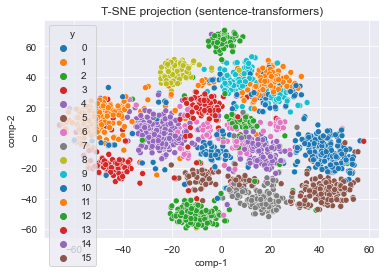

In [123]:
get_text_per_cluster(16)

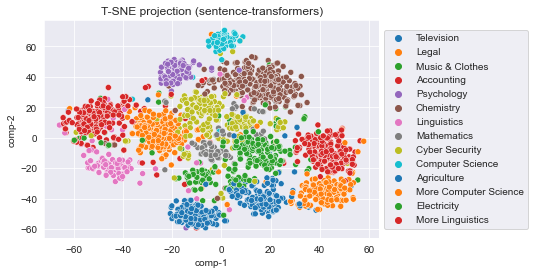

In [124]:
interpretation = ["Television", "Legal", "Music & Clothes", "Accounting", "Psychology", "Chemistry", "Linguistics", "Mathematics", "Cyber Security", "Computer Science", "Agriculture", "More Computer Science", "Electricity", "More Linguistics", "Art", "Aviation"]
get_plot_using_interpretation(interpretation)

## Bisecting K-meanst
This code is copied from [here]().

In [77]:
from sklearn.cluster import KMeans
import numpy as np

K = 12
current_clusters = 1
X = sentence_embeddings
while current_clusters != K+1:
    # print("Current clusters:", current_clusters)
    kmeans = KMeans(n_clusters=2).fit(X)
    current_clusters += 1
    cluster_centers = kmeans.cluster_centers_
    sse = [0]*2
    for point, label in zip(X, kmeans.labels_):
        sse[label] += np.square(point-cluster_centers[label]).sum()
    chosen_cluster = np.argmax(sse, axis=0)
    chosen_cluster_data = X[kmeans.labels_ == chosen_cluster]
    print(f"After cluster {current_clusters}: Chosen cluster size: {len(chosen_cluster_data)}; Other size: {len(X)-len(chosen_cluster_data)}")
    X = chosen_cluster_data

After cluster 2: Chosen cluster size: 1339; Other size: 761
After cluster 3: Chosen cluster size: 971; Other size: 368
After cluster 4: Chosen cluster size: 734; Other size: 237
After cluster 5: Chosen cluster size: 531; Other size: 203
After cluster 6: Chosen cluster size: 372; Other size: 159
After cluster 7: Chosen cluster size: 214; Other size: 158
After cluster 8: Chosen cluster size: 171; Other size: 43
After cluster 9: Chosen cluster size: 110; Other size: 61
After cluster 10: Chosen cluster size: 68; Other size: 42
After cluster 11: Chosen cluster size: 38; Other size: 30
After cluster 12: Chosen cluster size: 24; Other size: 14
After cluster 13: Chosen cluster size: 13; Other size: 11
Debug


# Write to file

In [128]:
model = KMeans(n_clusters=15, random_state=0).fit(sentence_embeddings)

titles = articles.title.values
labels = model.fit_predict(sentence_embeddings)

assert len(titles) == len(labels)

file = open("clusters.tsv", "w+", encoding="utf-8")
for title, label in zip(titles, labels):
    # print(f"{title}\t{label}\n")
    file.write(f"{title}\t{label}\n")
file.close()